In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Oct 29, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter
from skimage.measure import compare_ssim as ssim

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image
import scipy
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras import backend
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import Callback
from keras.losses import mean_squared_error
from keras.utils.np_utils import to_categorical
from keras.models import Model

from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

# model = load_model('./tmp/SR_FeatureWise.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
#                                                     'charbonnierLoss': charbonnierLoss})

# SRx2_Fiji_4channel_EDSR.h5
# SR_model = load_model('./tmp/SRx2_Fiji_4channel_EDSR.h5', custom_objects={'PixelShuffler':NeMO_layers.PixelShuffler, 'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
SR_model = load_model('./tmp/SRx2_4channel_GAN_Refine_v2.h5', custom_objects={'PixelShuffler':NeMO_layers.PixelShuffler, 'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
# SR_model.summary()
NeMO_model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

SR_model.summary()
# NeMO_model.summary()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 4)   0                                            
____________________________________________________________________________________________________
vgg_convblock1_conv1 (Conv2D)    (None, 128, 128, 64)  2368        input_1[0][0]                    
____________________________________________________________________________________________________
vgg_convblock2_par1_str1_par1_co (None, 128, 128, 64)  36928       vgg_convblock1_conv1[0][0]       
__________________________________________________________________________

In [2]:
def loadrasterRGB(filepath,channels):
    img = gdal.Open(filepath)

    xsize = img.RasterXSize
    ysize = img.RasterYSize

    image = np.zeros((ysize,xsize,len(channels)))

    for band in range(len(channels)):
        imgband = img.GetRasterBand(channels[band])
        image[:,:,band] = imgband.ReadAsArray()
    return image

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval):
    fixed_img = img
    fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=np.uint8)
    return fixed_img

def raster_lores(filepath, downscale):
    img = gdal.Open(filepath)
    xsize = img.RasterXSize
    ysize = img.RasterYSize
    channels = img.RasterCount
     
    downscalesize_x = int(xsize*downscale)
    downscalesize_y = int(ysize*downscale)
    
    lores_image = np.zeros((downscalesize_y, downscalesize_x, channels))
    
    for band in range(channels):
        imgband = img.GetRasterBand(band+1).ReadAsArray()
        lores_image_channel = scipy.misc.imresize(imgband, downscale, mode='F')
        lores_image[:,:,band] = lores_image_channel
        
    return lores_image

def classifyback(predictions):
    return np.argmax(predictions,-1)

<IPython.core.display.Javascript object>


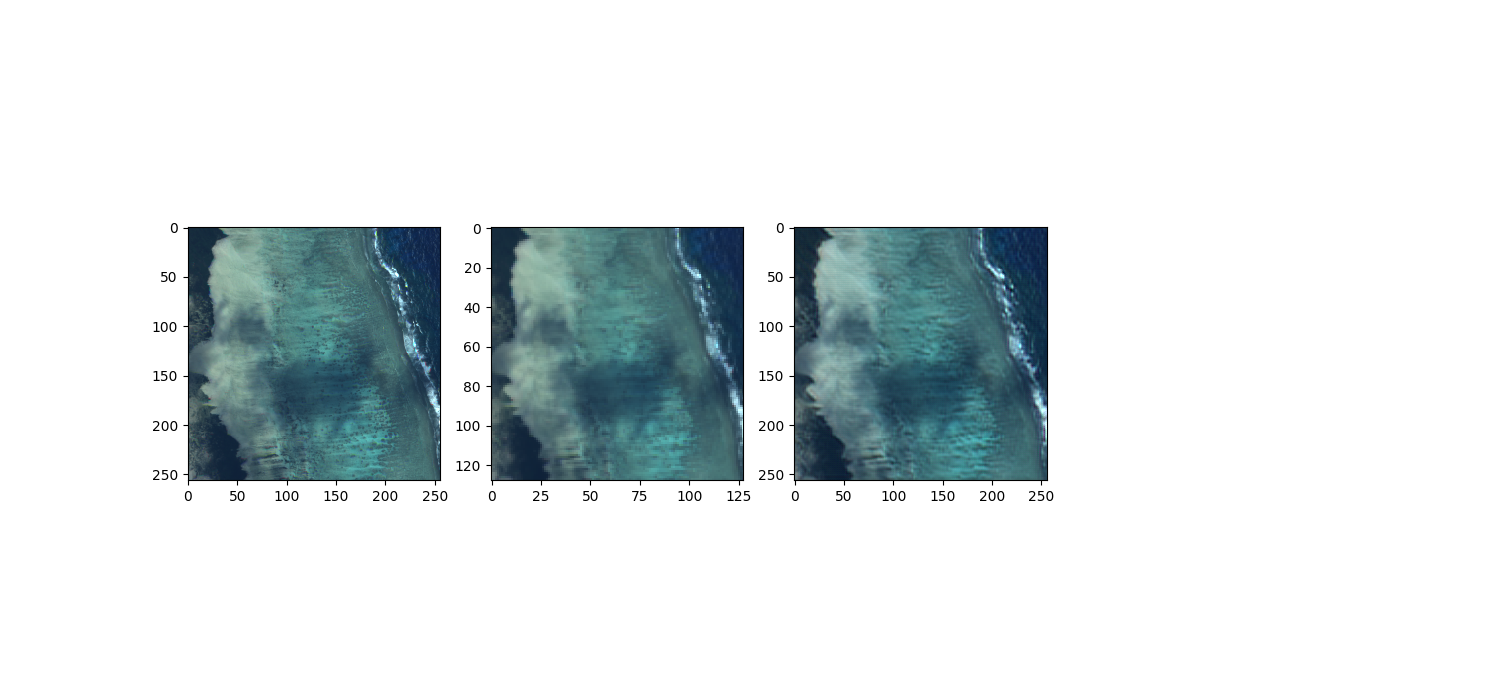

In [85]:
filepath_lores = "/home/asli/NeMO-Test/NeMO-NET/Images/Fiji_SR_Patches_v2_128/Back reef coral bommies/Back reef coral bommies_00000001.tif"
filepath_hires = "/home/asli/NeMO-Test/NeMO-NET/Images/Fiji_SR_Patches_v2_256/Back reef coral bommies/Back reef coral bommies_00000001.tif"
RGBchannels = [5,3,2]
BGRNIRchannels = [2,3,5,7]

Fiji_lores = loadrasterRGB(filepath_lores, RGBchannels)
Fiji_hires = loadrasterRGB(filepath_hires, RGBchannels)

image_lores = fixRGBimg(Fiji_lores, 0, 1, 0, 255)
image_hires = fixRGBimg(Fiji_hires, 0, 1, 0, 255)

image_loresinput = loadrasterRGB(filepath_lores, BGRNIRchannels)
image_loresinput = (image_loresinput-100)/100
imgbatch = np.expand_dims(image_loresinput, axis=0)
imgpredict = SR_model.predict(imgbatch, batch_size = 1)[0]
imgpredict = fixRGBimg(imgpredict,100,100,0,255)

imgpredict_fix = np.zeros((imgpredict.shape[0],imgpredict.shape[1],4))
imgpredict_fix[:,:,0] = imgpredict[:,:,2]
imgpredict_fix[:,:,1] = imgpredict[:,:,1]
imgpredict_fix[:,:,2] = imgpredict[:,:,0]
imgpredict_fix[:,:,3] = imgpredict[:,:,3]
imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,4,1)
ax.imshow(image_hires)

ax = fig.add_subplot(1,4,2)
ax.imshow(image_lores)
plt.show()

ax = fig.add_subplot(1,4,3)
ax.imshow(imgpredict_fix[:,:,:3])
plt.show()

/home/asli/NeMO-Test/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


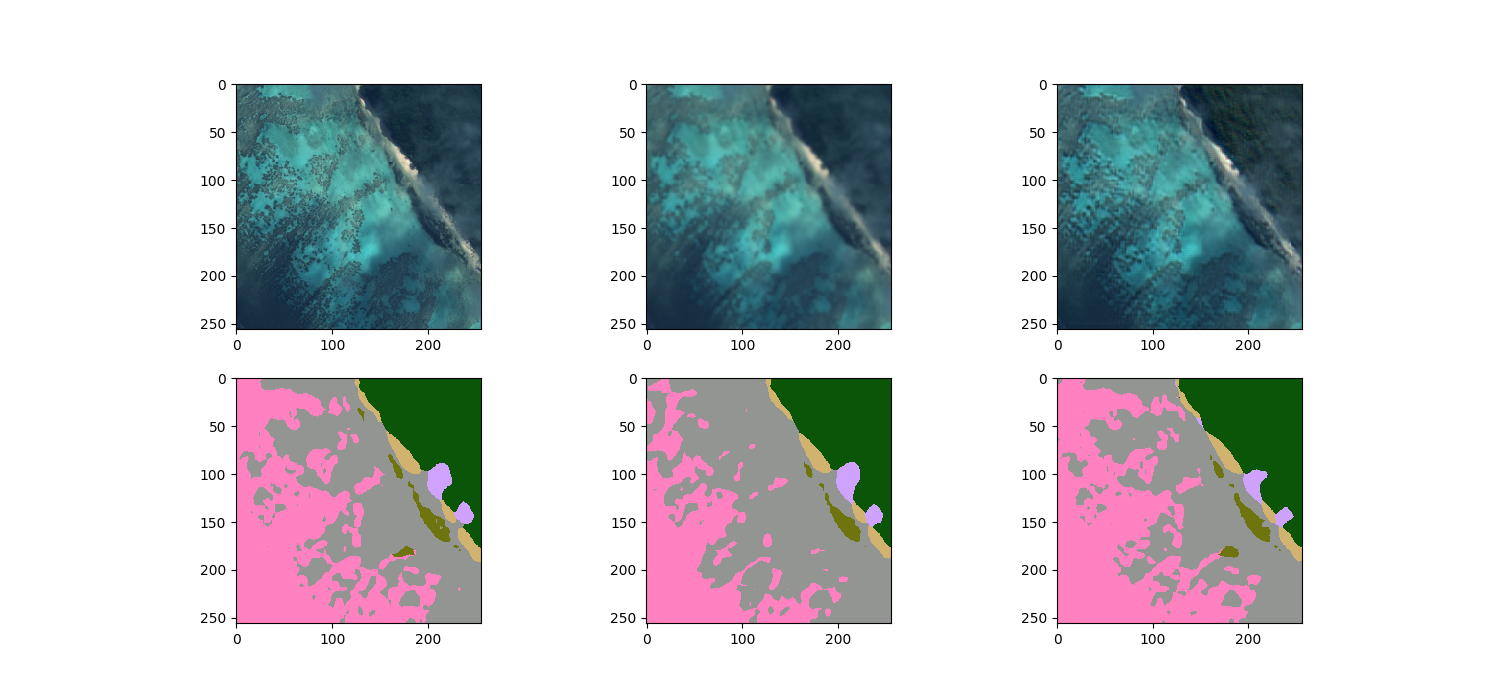

In [108]:
import scipy

output_layer = SR_model.get_layer("pixel_shuffler_1").output
mdl = Model(SR_model.input, output_layer)
mdl.trainable = False

filepath_lores = "/home/asli/NeMO-Test/NeMO-NET/Images/Fiji_SR_Patches_v2_128/Back reef coral bommies/Back reef coral bommies_00000006.tif"
filepath_hires = "/home/asli/NeMO-Test/NeMO-NET/Images/Fiji_SR_Patches_v2_256/Back reef coral bommies/Back reef coral bommies_00000006.tif"

image_loresinput = loadrasterRGB(filepath_lores, BGRNIRchannels)
image_loresinput = (image_loresinput-100)/100
imgbatch = np.expand_dims(image_loresinput, axis=0)
imgpredict = SR_model.predict(imgbatch, batch_size = 1)

imgpredict_fix = np.zeros((imgpredict.shape[1],imgpredict.shape[2],4))
imgpredict_fix[:,:,0] = imgpredict[0,:,:,2]
imgpredict_fix[:,:,1] = imgpredict[0,:,:,1]
imgpredict_fix[:,:,2] = imgpredict[0,:,:,0]
imgpredict_fix[:,:,3] = imgpredict[0,:,:,3]
imgpredict_fix = fixRGBimg(imgpredict_fix,100,100,0,255)
imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)

image_hires = loadrasterRGB(filepath_hires, BGRNIRchannels)
image_hiresinput = fixRGBimg(image_hires, 0, 1, 0, 255)
imghires_fix = np.zeros((image_hiresinput.shape[0],image_hiresinput.shape[1],4))
imghires_fix[:,:,0] = image_hiresinput[:,:,2]
imghires_fix[:,:,1] = image_hiresinput[:,:,1]
imghires_fix[:,:,2] = image_hiresinput[:,:,0]
imghires_fix[:,:,3] = image_hiresinput[:,:,3]
imghires_fix = np.asarray(imghires_fix, dtype=np.uint8)
image_hiresinput = (image_hires-100)/100
imghi_batch = np.expand_dims(image_hiresinput, axis=0)

image_lores = loadrasterRGB(filepath_lores, BGRNIRchannels)
image_loresinput = fixRGBimg(image_lores, 0, 1, 0, 255)
image_lores_upsample = np.zeros((image_loresinput.shape[0]*2,image_loresinput.shape[1]*2,4))
for i in range(4):
    image_lores_upsample[:,:,i] = scipy.misc.imresize(image_loresinput[:,:,i], 200)
imglores_fix = np.zeros((image_lores_upsample.shape[0],image_lores_upsample.shape[1],4))
imglores_fix[:,:,0] = image_lores_upsample[:,:,2]
imglores_fix[:,:,1] = image_lores_upsample[:,:,1]
imglores_fix[:,:,2] = image_lores_upsample[:,:,0]
imglores_fix[:,:,3] = image_lores_upsample[:,:,3]
imglores_fix = np.asarray(imglores_fix, dtype=np.uint8)
image_loresinput = (image_lores_upsample-100)/100
imglo_batch = np.expand_dims(image_loresinput, axis=0)


sr_predict = NeMO_model.predict(imgpredict)[0]
sr_predict = np.argmax(np.reshape(sr_predict, (256,256,9)), -1)

lr_predict = NeMO_model.predict(imglo_batch)[0]
lr_predict = np.argmax(np.reshape(lr_predict, (256,256,9)), -1)

hr_predict = NeMO_model.predict(imghi_batch)[0]
hr_predict= np.argmax(np.reshape(hr_predict, (256,256,9)), -1)


cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(2,3,1)
ax.imshow(imghires_fix[:,:,:3])

ax = fig.add_subplot(2,3,2)
ax.imshow(imglores_fix[:,:,:3])

ax = fig.add_subplot(2,3,3)
ax.imshow(imgpredict_fix[:,:,:3])

ax = fig.add_subplot(2,3,4)
ax.imshow(hr_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = fig.add_subplot(2,3,5)
ax.imshow(lr_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = fig.add_subplot(2,3,6)
ax.imshow(sr_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

plt.show()


(4271, 8965, 4)
2019-10-13T21:51:35.887451Z


<IPython.core.display.Javascript object>


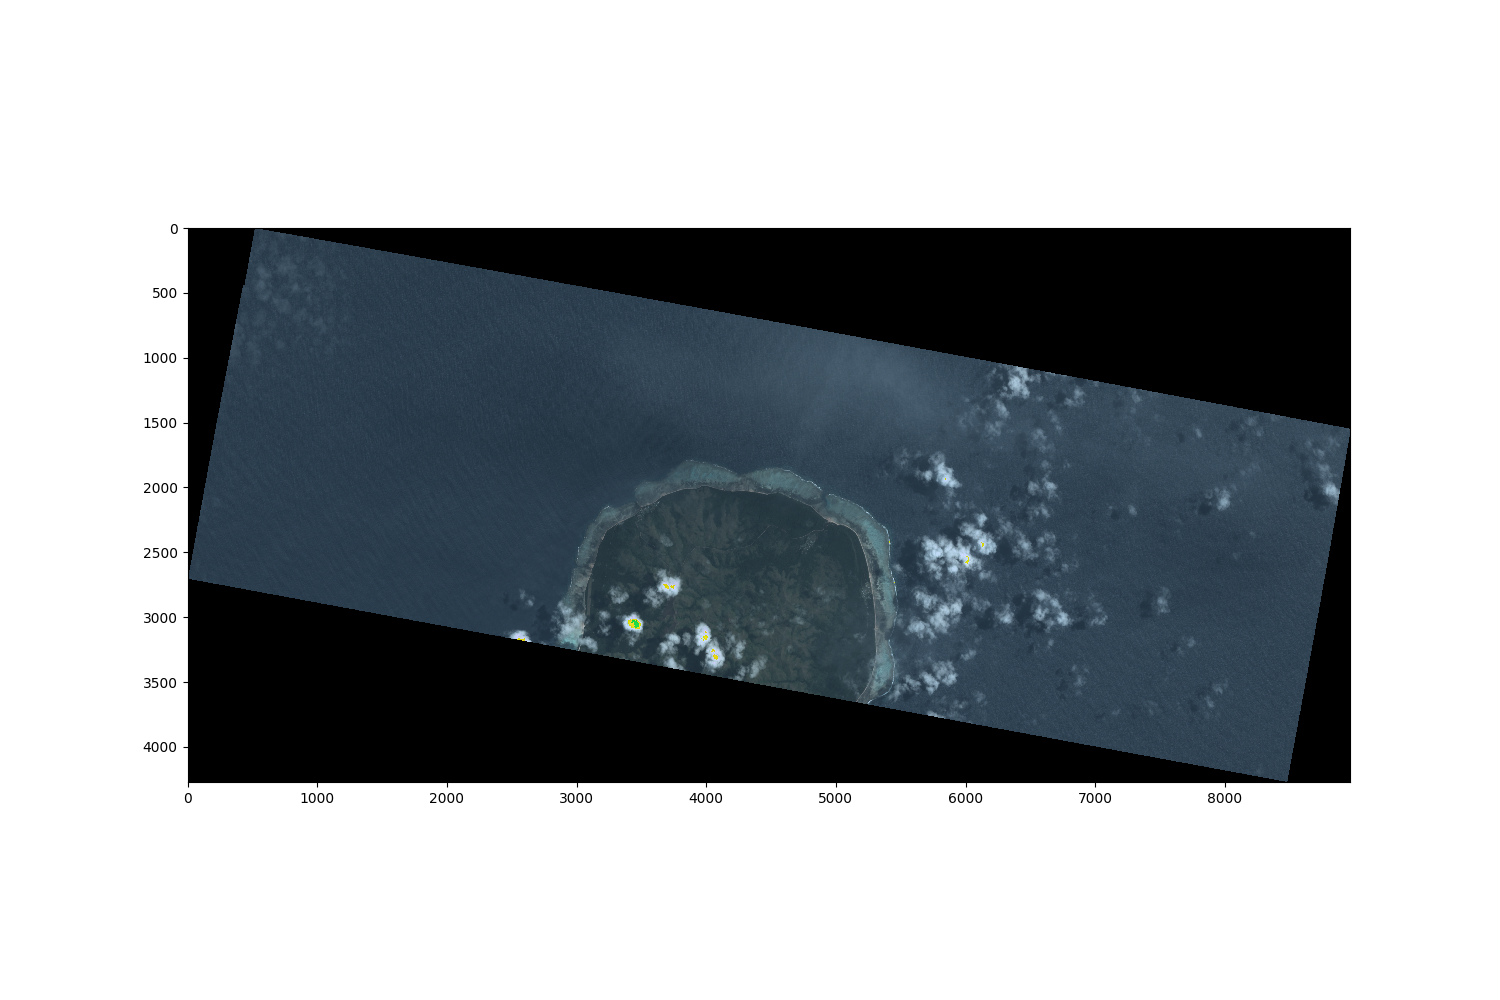

maximums: [336.6135  238.20647 291.35535 190.85025]


In [3]:
import math

infopath = '/home/asli/NeMO-Test/NeMO-NET/Images/ForJarrett_SpecificTrainTruth_512/CoralInfo.txt'
imgnum = 18
# GoodPlanetData = ['09', '10', '11', '14', '15', '18', '19']

with open(infopath) as fp:
    line = fp.readline()
    cnt = 1
    while cnt <= imgnum: 
        line = fp.readline()
        cnt += 1
linesplit = line.split()
xstart = int(linesplit[-1])
ystart = int(linesplit[-2])
imgpath = " ".join(linesplit[:-2])
jsonpath = imgpath[:imgpath.find('3B_AnalyticMS.tif')] + 'metadata.json'
xmlpath = imgpath[:imgpath.find('3B_AnalyticMS.tif')] + '3B_AnalyticMS_metadata.xml'

img = coralutils.CoralData(imgpath, load_type="raster")

with open(jsonpath) as json_file:
    json_data = json.load(json_file)
    
print(img.image.shape)
img.truthimage = np.zeros(img.image.shape)

## calculate sun-earth distance
##------------------------------
## this function accepts acquisition time and calculates sun-earth distance
## this is used in the correction of toa radiance for solar geometry
## input: AcqTime: earliestAcqTime str from WV2 .IMD file format: YYYY_MM_DDThh:mm:ss:ddddddZ;
## output: d_ES in astromnomical units
##--------------------------------------------------------------------------------------------

def calc_d_ES( AcqTime ):
    
    AcqTime = AcqTime.strip()
    print(AcqTime)
    year    = int(AcqTime[0:4])
    month_  = AcqTime[5:7]
    month   = int(month_.lstrip("0"))
    day_    = AcqTime[8:10]
    day     = int(day_.lstrip("0"))
    hh_     = AcqTime[11:13]
    hh      = float(hh_.lstrip("0"))
    mm_     = AcqTime[14:16]
    mm      = float(mm_.lstrip("0"))
    ss_     = AcqTime[17:19]
    ss      = float(ss_.lstrip("0"))
    ms    = float(AcqTime[20:-1])
    sec   = ss + ms/(1e6)
    
    UT   = hh + mm/60. + sec/3600.
    #print("UT: ",UT)
    
    if (month == 1 or month == 2):
        year = year - 1
        month= month + 12
        
    # calculate Juliad Day (Meeus, p.61, 1998)
    A = int(year/100)
    B = 2 - A + int(A/4)
    JD= int(365.25*(year+4716)) + int(30.6001*(month + 1)) + day + UT/24. + B - 1524.5
    #print("Julian Day: ", JD)
    # calculate Earth-Sun distance (U.S. Naval Observatory)
    D  = JD - 2451545.0
    g  = 357.529 + 0.98560028*D
    gi = math.cos(math.radians(g))
    gi2= math.cos(math.radians(2*g))
    
    d_ES = 1.00014 - 0.01671*gi - 0.00014*gi2
    #print(d_ES)
    
    return (d_ES)**2

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval,dtype=np.uint8):
    fixed_img = np.copy(img)
    if type(pixel_std) == list:
        for i,std in enumerate(pixel_std):
            fixed_img[:,:,i] = fixed_img[:,:,i]*std+pixel_mean
    else:
        fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=dtype)
    return fixed_img

TOA_radiance_img = fixRGBimg(img.image,0,0.01,0,10000,np.float32) # turn into 0-255
AcqTimeAll = json_data["properties"]['acquired']
d_ES_sq = calc_d_ES(AcqTimeAll)
meanSZA = 90.-json_data["properties"]["sun_elevation"]
mu = math.cos(math.radians(meanSZA))
GEO_radiance_img = (TOA_radiance_img*d_ES_sq)/mu

fig = plt.figure(figsize=(15,10))
pic = np.rollaxis(np.asarray([GEO_radiance_img[:,:,2], GEO_radiance_img[:,:,1], GEO_radiance_img[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()

print("maximums:", np.max(np.reshape(GEO_radiance_img,(img.image.shape[0]*img.image.shape[1],img.image.shape[2])),0))

<IPython.core.display.Javascript object>


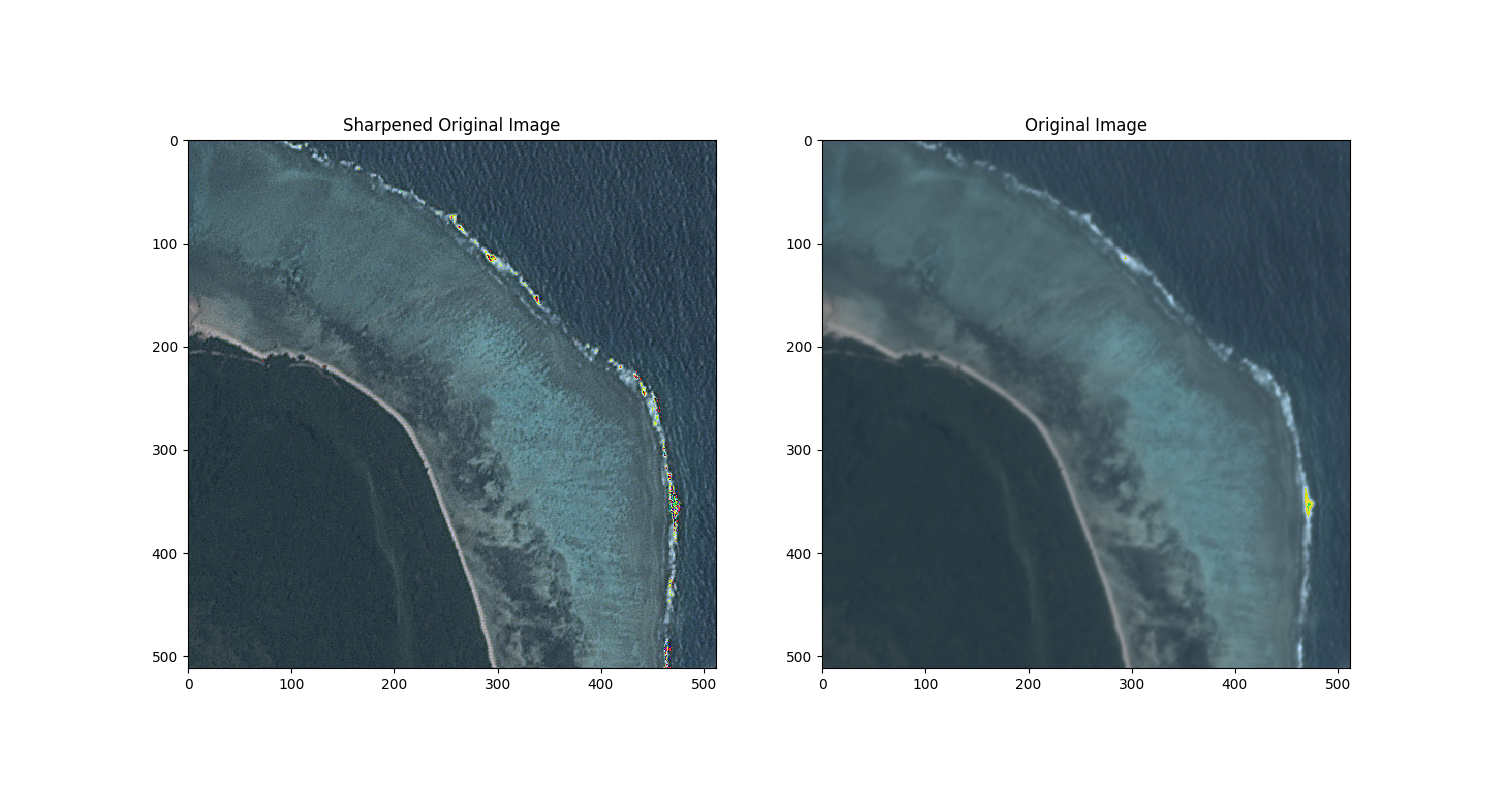

<IPython.core.display.Javascript object>


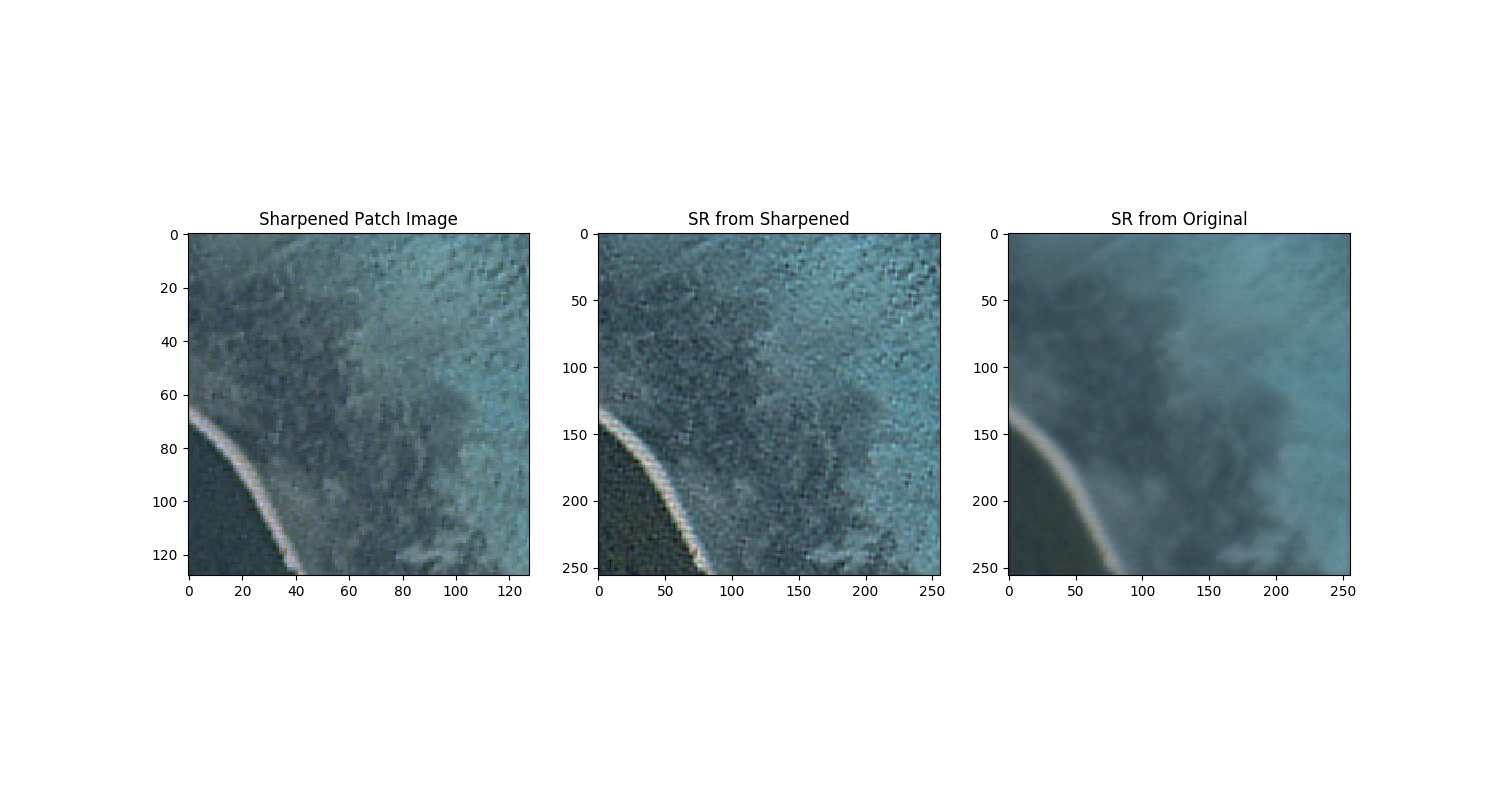

In [13]:
from keras.preprocessing.image import img_to_array, load_img
import keras.backend as K

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

# Southwest
# xgeo = 251600.0
# ygeo = 8033931.0

# North
# xgeo = 253479.0
# ygeo = 8040132.0 

# Northeast
ygeo = 8039001.0
xgeo = 257200.0

xstart = int((xgeo-img.geotransform[0])/img.geotransform[1])
ystart = int((ygeo-img.geotransform[3])/img.geotransform[5])

xlen = 512
ylen = 512

imgshape = img.image.shape
if xstart+xlen > imgshape[1] or xstart < 0 or ystart+ylen > imgshape[0] or ystart < 0:
    print("Image out of bounds!")
else:
    predict_size = 128
    crop_len = int(np.floor(256/2))
    offstart = crop_len-int(np.floor(predict_size/2))
    
    img.testimage = np.copy(GEO_radiance_img[ystart:ystart+ylen,xstart:xstart+xlen,:])
    kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    for i in range(4):
        img.testimage[:,:,i] = cv2.filter2D(img.testimage[:,:,i], -1, kernel_sharpening)


    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(121)
    sharpened_img = np.rollaxis(np.asarray([img.testimage[:,:,2], img.testimage[:,:,1], img.testimage[:,:,0]]),0,3)
    sharpened_img = np.asarray(sharpened_img, dtype=np.uint8) 
    ax.title.set_text('Sharpened Original Image')
    ax.imshow(sharpened_img) # Sharpened original image
#     rect = mpatches.Rectangle((128,128),256,256,linewidth=1,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)

    ax = plt.subplot(122)
    ax.imshow(np.asarray(GEO_radiance_img[ystart:ystart+ylen,xstart:xstart+xlen,2::-1],dtype=np.uint8))
    ax.title.set_text('Original Image')
    plt.show()

    pixel_mean = 100
    pixel_std = 75
    yystart = 192
    xxstart = 192
    img_sharpen = np.copy(img.testimage[yystart:yystart+128, xxstart:xxstart+128, :])
    
    fig = plt.figure(figsize=(15,8))
    ax = plt.subplot(131)
    ax.imshow(np.asarray(img_sharpen[:,:,2::-1], dtype=np.uint8))
    ax.title.set_text('Sharpened Patch Image')
    
    samplepatch_sharpened = img_to_array(img_sharpen, data_format=K.image_data_format())
    samplepatch_sharpened = (samplepatch_sharpened-pixel_mean)/pixel_std
    
imgbatch_sharpened = np.expand_dims(samplepatch_sharpened, axis=0)
imgpredict_sharpened = SR_model.predict(imgbatch_sharpened, batch_size = 1)
imgpredict_RGB_sharpened = np.rollaxis(np.asarray([imgpredict_sharpened[0,:,:,2], imgpredict_sharpened[0,:,:,1], imgpredict_sharpened[0,:,:,0], imgpredict_sharpened[0,:,:,3]]),0,3)
imgpredict_RGB_sharpened = fixRGBimg(imgpredict_RGB_sharpened, 100, 75, 0, 255)
ax = plt.subplot(132)
ax.imshow(imgpredict_RGB_sharpened[:,:,:3])
ax.title.set_text('SR from Sharpened')

samplepatch_original = np.copy(GEO_radiance_img[ystart:ystart+ylen,xstart:xstart+xlen,:])
samplepatch_original = img_to_array(samplepatch_original, data_format=K.image_data_format())
samplepatch_original = (samplepatch_original-pixel_mean)/pixel_std
imgbatch_original = np.expand_dims(samplepatch_original[yystart:yystart+128, xxstart:xxstart+128, :], axis=0)
imgpredict_original = SR_model.predict(imgbatch_original, batch_size = 1)
imgpredict_RGB_original = np.rollaxis(np.asarray([imgpredict_original[0,:,:,2], imgpredict_original[0,:,:,1], imgpredict_original[0,:,:,0], imgpredict_original[0,:,:,3]]),0,3)
imgpredict_RGB_original = fixRGBimg(imgpredict_RGB_original, 100, 75, 0, 255)
ax = plt.subplot(133)
ax.imshow(imgpredict_RGB_original[:,:,:3])
ax.title.set_text('SR from Original')
# imgpredict_sharpen = np.copy(imgpredict_RGB)
# for i in range(4):
#     imgpredict_sharpen[:,:,i] = cv2.filter2D(imgpredict_sharpen[:,:,i], -1, kernel_sharpening)
# ax = plt.subplot(133)
# ax.imshow(imgpredict_sharpen[:,:,:3])
# ax.title.set_text('Sharpen Predicted from Sharpened')

plt.show()

<IPython.core.display.Javascript object>


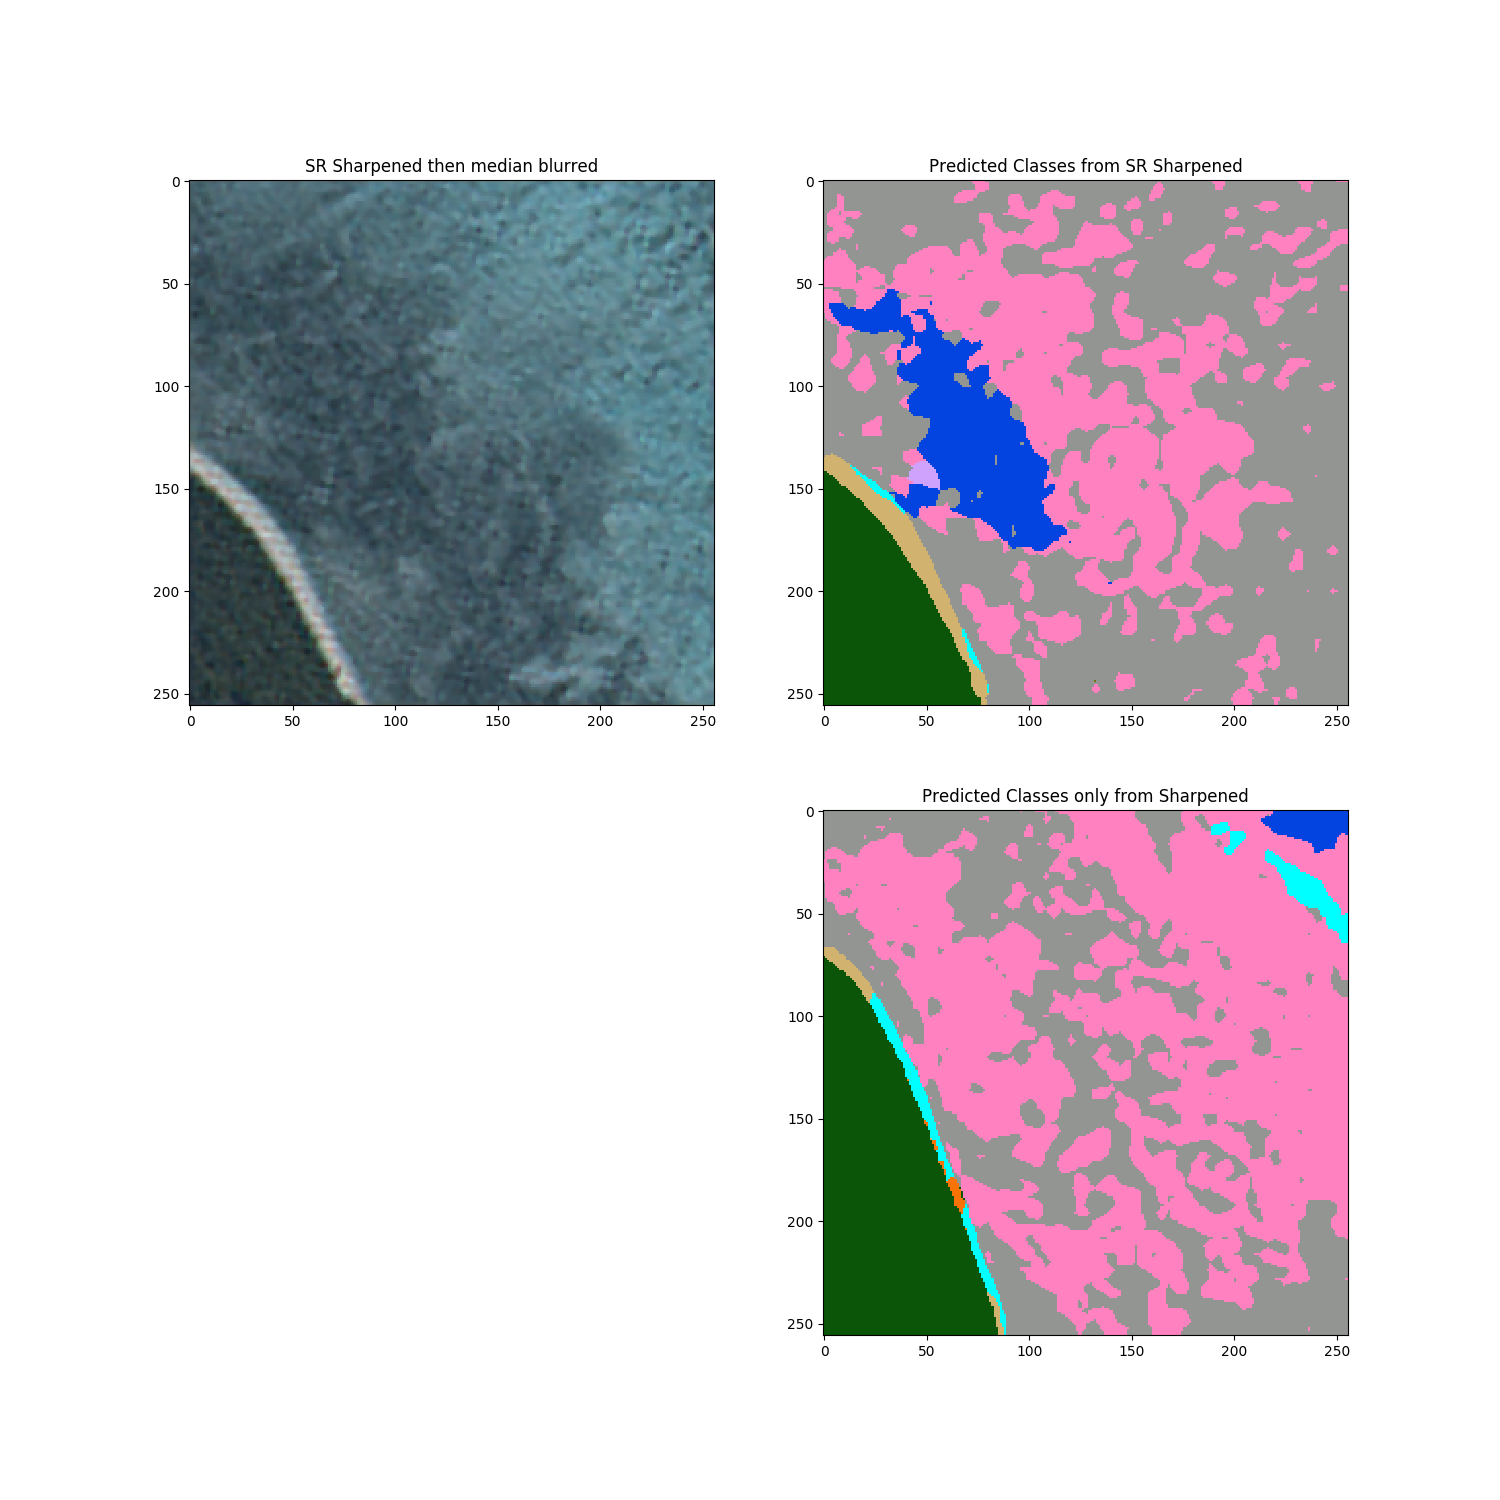

In [31]:
from scipy import ndimage, misc

# imgpredict_sharpen_medianblur = np.copy(imgpredict_sharpened)
# for i in range(4):
#     imgpredict_sharpen_medianblur[0,:,:,i] = ndimage.median_filter(imgpredict_sharpen_medianblur[0,:,:,i], size=3)

sr_predict_sharpened = NeMO_model.predict(imgpredict_sharpen_medianblur)[0]
sr_predict_sharpened = np.argmax(np.reshape(sr_predict_sharpened, (256,256,9)), -1)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

fig = plt.figure(figsize=(15,15))
ax = plt.subplot(221)
imgpredict_RGB_sharpen_medianblur = np.rollaxis(np.asarray([imgpredict_sharpen_medianblur[0,:,:,2], imgpredict_sharpen_medianblur[0,:,:,1], imgpredict_sharpen_medianblur[0,:,:,0], imgpredict_sharpen_medianblur[0,:,:,3]]),0,3)
imgpredict_RGB_sharpen_medianblur = fixRGBimg(imgpredict_RGB_sharpen_medianblur, 100, 75, 0, 255)
ax.imshow(imgpredict_RGB_sharpen_medianblur[:,:,:3])
ax.title.set_text('SR Sharpened then median blurred')

ax = plt.subplot(222)
ax.imshow(sr_predict_sharpened.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
ax.title.set_text('Predicted Classes from SR Sharpened')

# ax = plt.subplot(223)
# imgpredict_RGB_orig_sharpen = np.rollaxis(np.asarray([imgpredict_orig_sharpen[0,:,:,2], imgpredict_orig_sharpen[0,:,:,1], imgpredict_orig_sharpen[0,:,:,0], imgpredict_orig_sharpen[0,:,:,3]]),0,3)
# imgpredict_RGB_orig_sharpen = fixRGBimg(imgpredict_RGB_orig_sharpen, 100, 75, 0, 255)
# ax.imshow(imgpredict_RGB_orig_sharpen[:,:,:3])
# ax.title.set_text('SR Original')

# ax = plt.subplot(224)
# ax.imshow(sr_predict_original.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# ax.title.set_text('Predicted Classes from SR Original')


img_sharpen = np.copy(img.testimage[yystart:yystart+256, xxstart:xxstart+256, :])
samplepatch = img_to_array(img_sharpen, data_format=K.image_data_format())
samplepatch = (samplepatch-pixel_mean)/pixel_std


imgbatch = np.expand_dims(samplepatch, axis=0)
predict_sharpened = NeMO_model.predict(imgbatch)[0]
predict_sharpened= np.argmax(np.reshape(predict_sharpened, (256,256,9)), -1)
ax = plt.subplot(224)
ax.imshow(predict_sharpened.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
ax.title.set_text('Predicted Classes only from Sharpened')

plt.show()
    